In [391]:
import pandas as pd
from catomatic.BinaryCatalogue import BinaryBuilder
from matplotlib_venn import venn2
import matplotlib.pyplot as plt
import utils
import os
import math
import pandas as pd
import numpy as np
import piezo

import warnings
import json
import seaborn as sns

warnings.simplefilter("ignore", category=DeprecationWarning)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Catalogue construction workflow

Below is the workflow used to build a catalogue from a mutations table and a samples table, applied to rifampicin as an example. 

### Prepare Mutations Input

In [30]:
def prep_mutations(file_path):
    mutations = pd.read_csv(file_path)
    mutations.columns = mutations.columns.str.upper()

    #create mutations columns in piezo grammar
    mutations['MUTATION'] = mutations.apply(lambda x: f"{x['GENE']}@{x['MUTATION']}", axis=1)
    #flag synonymous mutations
    mutations["IS_SYNONYMOUS"] = mutations["MUTATION"].apply(lambda x: x.split("@")[-1][0] == x.split("@")[-1][-1])
    #filter out synonymous mutations
    mutations = mutations[~mutations.IS_SYNONYMOUS]
    # filter relevant columns for catomatic and rename id column
    mutations = mutations[['ENA_RUN', 'MUTATION', 'FRS']].rename(columns={'ENA_RUN': 'UNIQUEID'})
    return mutations

mutations = prep_mutations('./data/old/training/MUTATIONS_training_rpoB_subset.csv')
mutations

,UNIQUEID,MUTATION,FRS
0,ERR025834,rpoB@c-61t,1.000
3,ERR025835,rpoB@c-61t,1.000
6,ERR025836,rpoB@c-61t,1.000
14,ERR038260,rpoB@c-61t,1.000
17,ERR038261,rpoB@c-61t,1.000
...,...,...,...
32967,SRR671867,rpoB@D435V,1.000
32969,SRR671868,rpoB@S450L,1.000
32970,SRR671869,rpoB@L430P,0.979
32971,SRR671869,rpoB@H445N,1.000


### Prepare Samples (phenotypes) Input

In [ ]:
def prep_phenotypes(file_path, drug):
    phenotypes = pd.read_csv(file_path)
    phenotypes.columns = phenotypes.columns.str.upper()
    #filter for drug
    phenotypes = phenotypes[phenotypes.DRUG==drug]
    #discoard low quality phenotypes
    phenotypes = phenotypes[phenotypes.PHENOTYPE_QUALITY.isin(['HIGH', 'MEDIUM', 'Unknown'])]
    #filter out non R/S phenotypes
    phenotypes = phenotypes[phenotypes.PHENOTYPE.isin(['R', 'S'])]
    #handle duplicates (keep R if R, otherwise first)
    phenotypes = phenotypes.groupby("ENA_RUN", group_keys=False).apply(utils.filter_multiple_phenos).reset_index(drop=True)
    # filter relevant columns for catomatic and rename id column
    phenotypes = phenotypes[['ENA_RUN', 'DRUG', 'PHENOTYPE']].rename(columns={'ENA_RUN': 'UNIQUEID'})
    return phenotypes

phenotypes = prep_phenotypes('./creating_training_validation_sets/cat_drug_long_format_20250117.csv', 'RIF')
phenotypes

,UNIQUEID,DRUG,PHENOTYPE
0,ERR025833,RIF,S
1,ERR025834,RIF,S
2,ERR025835,RIF,S
3,ERR025836,RIF,S
4,ERR025837,RIF,S
...,...,...,...
22914,SRR671875,RIF,S
22915,SRR671876,RIF,S
22916,SRR671877,RIF,S
22917,SRR671878,RIF,S


In [ ]:
pd.read_csv('./creating_training_validation_sets/cat_drug_long_format_20250117.csv')['drug'].value_counts()

drug
AMI    25033
BDQ    25033
RIF    25033
RFB    25033
PZA    25033
PAS    25033
OXF    25033
MXF    25033
LZD    25033
LEV    25033
KAN    25033
INH    25033
ETH    25033
EMB    25033
DLM    25033
CS     25033
CFZ    25033
CIP    25033
CAP    25033
STR    25033
Name: count, dtype: int64

### Build the catalogue 

In [4]:
catalogue = BinaryBuilder(samples = phenotypes, mutations = mutations, FRS=0.1).build(test='Binomial', background=0.05, strict_unlock=False)
catalogue_df = catalogue.build_piezo(genbank_ref='NC00962.3', catalogue_name='rif_demo', version='0.0', drug='RIF', wildcards="./data/wildcards/rif_wildcards.json", json_dumps=True)
catalogue_df.to_csv('./catalogues/temp/demo_rif_catalogue.csv')
catalogue_df

,GENBANK_REFERENCE,CATALOGUE_NAME,CATALOGUE_VERSION,CATALOGUE_GRAMMAR,PREDICTION_VALUES,DRUG,MUTATION,PREDICTION,SOURCE,EVIDENCE,OTHER
0,NC00962.3,rif_demo,0.0,GARC1,RUS,RIF,rpoB@c-61t,S,{},"{""proportion"": 0.011769834350479512, ""confiden...",{}
1,NC00962.3,rif_demo,0.0,GARC1,RUS,RIF,rpoB@M390T,S,{},"{""proportion"": 0.0, ""confidence"": [0.0, 0.3244...",{}
2,NC00962.3,rif_demo,0.0,GARC1,RUS,RIF,rpoB@D1006G,S,{},"{""proportion"": 0.0, ""confidence"": [0.0, 0.7934...",{}
3,NC00962.3,rif_demo,0.0,GARC1,RUS,RIF,rpoB@S12T,S,{},"{""proportion"": 0.0, ""confidence"": [0.0, 0.4344...",{}
4,NC00962.3,rif_demo,0.0,GARC1,RUS,RIF,rpoB@I925V,S,{},"{""proportion"": 0.0, ""confidence"": [4.868360917...",{}
...,...,...,...,...,...,...,...,...,...,...,...
258,NC00962.3,rif_demo,0.0,GARC1,RUS,RIF,rpoB@-*_indel,U,{},"{""default_rule"": ""True""}",{}
259,NC00962.3,rif_demo,0.0,GARC1,RUS,RIF,rpoB@*_indel,U,{},"{""default_rule"": ""True""}",{}
260,NC00962.3,rif_demo,0.0,GARC1,RUS,RIF,rpoB@-*?,U,{},"{""default_rule"": ""True""}",{}
261,NC00962.3,rif_demo,0.0,GARC1,RUS,RIF,rpoB@*?,U,{},"{""default_rule"": ""True""}",{}


Note: Kerri's wildcards (/data/old/wildcards.json) for rif include R classifications for all RRDR positions (but I haven't inluded these for now.)

In [5]:
catalogue_df.PREDICTION.value_counts()

PREDICTION
S    190
R     62
U     11
Name: count, dtype: int64

### Use the catalogue to predict phenotypes


Now that we have built a catalogue for rifampicin, we can apply a simple prediction algorithm to test its senstivity for predicting resistance.

We can do this on the same dataset used to build the catalogues, but crucially, we also have a totally independent validation set.

[[ 6708   317    12]
 [  401 15384    97]]
Catalogue coverage of isolates: 0.99524412059863
Sensitivity: 0.9548754448398576
Specificity: 0.9745961355717453


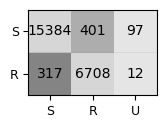

In [6]:
#test performance on training set

all = pd.merge(phenotypes, mutations[mutations.FRS>=0.1], on=['UNIQUEID'], how='left')
#note, this merge assumes the phenotypes df only contains samples that have been genotyped
cm = utils.piezo_predict(iso_df=all, drug='RIF', catalogue_file='./catalogues/temp/demo_rif_catalogue.csv', U_to_S=False, Print=True)[0]
cm = pd.DataFrame(cm, index=["R", "S"], columns=["R", "S", 'U'])

utils.plot_truthtables(cm, U_to_S=False, colors=["#666666", "#cccccc", "#999999", "#cccccc","#cccccc","#cccccc" ])

# Generate Catalogues for all drugs (parameter grid search)

There are a number of method-specific parameters that need to be optimised for each drug's data to generate a comprehensive catalogue. These include p-value of the statistical test, the background rate, and the fraction of read support for variants. 

FRS optimisation is a hot topic, and often reflects the essentiallity of the drug target. Therefore, this will be investigated seperately to the parameter search, after optimal background and p-values have been chosen.

In [ ]:
drug_mutations = {
    "AMI": "./data/old/training/MUTATIONS_training_eis_rrs_subset.csv",
    "CAP": "./data/old/training/MUTATIONS_training_rrs_tlyA_subset.csv",
    "CIP": "./data/old/training/MUTATIONS_training_gyrA_subset.csv",
    "DLM": "./data/old/training/MUTATIONS_training_ddn_subset.csv",
    "EMB": "./data/old/training/MUTATIONS_training_embA_embB_subset.csv",
    "ETH": "./data/old/training/MUTATIONS_training_ethA_fabG1_inhA_subset.csv",
    "INH": "./data/old/training/MUTATIONS_training_katG_inhA_ahpC_fabG1_subset.csv",
    "KAN": "./data/old/training/MUTATIONS_training_eis_rrs_subset.csv",
    "LEV": "./data/old/training/MUTATIONS_training_gyrA_gyrB_subset.csv",
    "LZD": "./data/old/training/MUTATIONS_training_rplC_subset.csv",
    "MXF": "./data/old/training/MUTATIONS_training_gyrA_gyrB_subset.csv",
    "OXF": "./data/old/training/MUTATIONS_training_gyrA_subset.csv",
    "RIF": "./data/old/training/MUTATIONS_training_rpoB_subset.csv",
    "STM": "./data/old/training/MUTATIONS_training_gid_rpsL_rrs_subset.csv"
}
#the conversion i use in tb_cat_builder are better - but just use kerris filenames for now


We need to generate catalogues using a grid search for each drug, and then test their performance on the training set to obtain sensitivity and specifcity values so we can decide on optimal parameters:

In [ ]:
#takes a while to run, so may want to split the predictions from the building step
FRS = 0.1
grid_results = {}

for drug, file in drug_mutations.items():
    grid_results[drug] = {}
    mutations = prep_mutations(file)
    phenotypes = prep_phenotypes('./creating_training_validation_sets/cat_drug_long_format_20250117.csv', drug)
    
    for background in [0.05, 0.10, 0.15, 0.20, 0.25]:
        for p in [0.9, 0.95, 0.975]:
            # Specify path at which to save the catalogue
            catfile = f"./catalogues/{drug.lower()}/bg_{background}_p_{p}_FRS_{FRS}.csv"
            # Generate and save the catalogue using this set of parameters
            catalogue = BinaryBuilder(samples=phenotypes, mutations=mutations, FRS=FRS).build(test='Binomial', background=background, strict_unlock=False)
            # Export the catalogue in piezo format
            catalogue.to_piezo(genbank_ref='NC00962.3',catalogue_name=f'{drug}-{background}-{p}',version='0.0',drug=drug,wildcards=f"./data/wildcards/{drug.lower()}_wildcards.json",json_dumps=True,outfile=catfile)
            
            # Test the performance of this catalogue on the training set
            all = pd.merge(phenotypes, mutations[mutations.FRS >= 0.1], on=['UNIQUEID'], how='left')
            cm, cov, sens, spec, _, _ = utils.piezo_predict(iso_df=all, drug=drug, catalogue_file=catfile, U_to_S=False, Print=False)
            
            # Save results into grid_results
            if background not in grid_results[drug]:
                grid_results[drug][background] = {}
            grid_results[drug][background][p] = {"cm": cm, "cov": cov, "sens": sens,"spec": spec}

OUTFILE ./catalogues/ami/bg_0.05_p_0.9_FRS_0.1.csv
OUTFILE ./catalogues/ami/bg_0.05_p_0.95_FRS_0.1.csv
OUTFILE ./catalogues/ami/bg_0.05_p_0.975_FRS_0.1.csv
OUTFILE ./catalogues/ami/bg_0.1_p_0.9_FRS_0.1.csv
OUTFILE ./catalogues/ami/bg_0.1_p_0.95_FRS_0.1.csv
OUTFILE ./catalogues/ami/bg_0.1_p_0.975_FRS_0.1.csv
OUTFILE ./catalogues/ami/bg_0.15_p_0.9_FRS_0.1.csv
OUTFILE ./catalogues/ami/bg_0.15_p_0.95_FRS_0.1.csv
OUTFILE ./catalogues/ami/bg_0.15_p_0.975_FRS_0.1.csv
OUTFILE ./catalogues/ami/bg_0.2_p_0.9_FRS_0.1.csv
OUTFILE ./catalogues/ami/bg_0.2_p_0.95_FRS_0.1.csv
OUTFILE ./catalogues/ami/bg_0.2_p_0.975_FRS_0.1.csv
OUTFILE ./catalogues/ami/bg_0.25_p_0.9_FRS_0.1.csv
OUTFILE ./catalogues/ami/bg_0.25_p_0.95_FRS_0.1.csv
OUTFILE ./catalogues/ami/bg_0.25_p_0.975_FRS_0.1.csv
OUTFILE ./catalogues/cap/bg_0.05_p_0.9_FRS_0.1.csv
OUTFILE ./catalogues/cap/bg_0.05_p_0.95_FRS_0.1.csv
OUTFILE ./catalogues/cap/bg_0.05_p_0.975_FRS_0.1.csv
OUTFILE ./catalogues/cap/bg_0.1_p_0.9_FRS_0.1.csv
OUTFILE ./catalogues

/var/folders/s5/pshvb2093574r5hqnwcy6klw0000gn/T/ipykernel_31358/2162113237.py:2: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  mutations = pd.read_csv(file_path)


OUTFILE ./catalogues/cip/bg_0.05_p_0.9_FRS_0.1.csv


/Users/dylanadlard/Documents/Oxford/PhD/Projects/cryptic-catalogues-2025/utils.py:608: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
/Users/dylanadlard/Documents/Oxford/PhD/Projects/cryptic-catalogues-2025/utils.py:609: RuntimeWarning: invalid value encountered in scalar divide
  specificity = cm[1, 1] / (cm[1, 1] + cm[1, 0])


OUTFILE ./catalogues/cip/bg_0.05_p_0.95_FRS_0.1.csv


/Users/dylanadlard/Documents/Oxford/PhD/Projects/cryptic-catalogues-2025/utils.py:608: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
/Users/dylanadlard/Documents/Oxford/PhD/Projects/cryptic-catalogues-2025/utils.py:609: RuntimeWarning: invalid value encountered in scalar divide
  specificity = cm[1, 1] / (cm[1, 1] + cm[1, 0])


OUTFILE ./catalogues/cip/bg_0.05_p_0.975_FRS_0.1.csv


/Users/dylanadlard/Documents/Oxford/PhD/Projects/cryptic-catalogues-2025/utils.py:608: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
/Users/dylanadlard/Documents/Oxford/PhD/Projects/cryptic-catalogues-2025/utils.py:609: RuntimeWarning: invalid value encountered in scalar divide
  specificity = cm[1, 1] / (cm[1, 1] + cm[1, 0])


OUTFILE ./catalogues/cip/bg_0.1_p_0.9_FRS_0.1.csv


/Users/dylanadlard/Documents/Oxford/PhD/Projects/cryptic-catalogues-2025/utils.py:608: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
/Users/dylanadlard/Documents/Oxford/PhD/Projects/cryptic-catalogues-2025/utils.py:609: RuntimeWarning: invalid value encountered in scalar divide
  specificity = cm[1, 1] / (cm[1, 1] + cm[1, 0])


OUTFILE ./catalogues/cip/bg_0.1_p_0.95_FRS_0.1.csv


/Users/dylanadlard/Documents/Oxford/PhD/Projects/cryptic-catalogues-2025/utils.py:608: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
/Users/dylanadlard/Documents/Oxford/PhD/Projects/cryptic-catalogues-2025/utils.py:609: RuntimeWarning: invalid value encountered in scalar divide
  specificity = cm[1, 1] / (cm[1, 1] + cm[1, 0])


OUTFILE ./catalogues/cip/bg_0.1_p_0.975_FRS_0.1.csv


/Users/dylanadlard/Documents/Oxford/PhD/Projects/cryptic-catalogues-2025/utils.py:608: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
/Users/dylanadlard/Documents/Oxford/PhD/Projects/cryptic-catalogues-2025/utils.py:609: RuntimeWarning: invalid value encountered in scalar divide
  specificity = cm[1, 1] / (cm[1, 1] + cm[1, 0])


OUTFILE ./catalogues/cip/bg_0.15_p_0.9_FRS_0.1.csv


/Users/dylanadlard/Documents/Oxford/PhD/Projects/cryptic-catalogues-2025/utils.py:608: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
/Users/dylanadlard/Documents/Oxford/PhD/Projects/cryptic-catalogues-2025/utils.py:609: RuntimeWarning: invalid value encountered in scalar divide
  specificity = cm[1, 1] / (cm[1, 1] + cm[1, 0])


OUTFILE ./catalogues/cip/bg_0.15_p_0.95_FRS_0.1.csv


/Users/dylanadlard/Documents/Oxford/PhD/Projects/cryptic-catalogues-2025/utils.py:608: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
/Users/dylanadlard/Documents/Oxford/PhD/Projects/cryptic-catalogues-2025/utils.py:609: RuntimeWarning: invalid value encountered in scalar divide
  specificity = cm[1, 1] / (cm[1, 1] + cm[1, 0])


OUTFILE ./catalogues/cip/bg_0.15_p_0.975_FRS_0.1.csv


/Users/dylanadlard/Documents/Oxford/PhD/Projects/cryptic-catalogues-2025/utils.py:608: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
/Users/dylanadlard/Documents/Oxford/PhD/Projects/cryptic-catalogues-2025/utils.py:609: RuntimeWarning: invalid value encountered in scalar divide
  specificity = cm[1, 1] / (cm[1, 1] + cm[1, 0])


OUTFILE ./catalogues/cip/bg_0.2_p_0.9_FRS_0.1.csv
OUTFILE ./catalogues/cip/bg_0.2_p_0.95_FRS_0.1.csv
OUTFILE ./catalogues/cip/bg_0.2_p_0.975_FRS_0.1.csv
OUTFILE ./catalogues/cip/bg_0.25_p_0.9_FRS_0.1.csv
OUTFILE ./catalogues/cip/bg_0.25_p_0.95_FRS_0.1.csv
OUTFILE ./catalogues/cip/bg_0.25_p_0.975_FRS_0.1.csv
OUTFILE ./catalogues/dlm/bg_0.05_p_0.9_FRS_0.1.csv
OUTFILE ./catalogues/dlm/bg_0.05_p_0.95_FRS_0.1.csv
OUTFILE ./catalogues/dlm/bg_0.05_p_0.975_FRS_0.1.csv
OUTFILE ./catalogues/dlm/bg_0.1_p_0.9_FRS_0.1.csv
OUTFILE ./catalogues/dlm/bg_0.1_p_0.95_FRS_0.1.csv
OUTFILE ./catalogues/dlm/bg_0.1_p_0.975_FRS_0.1.csv
OUTFILE ./catalogues/dlm/bg_0.15_p_0.9_FRS_0.1.csv
OUTFILE ./catalogues/dlm/bg_0.15_p_0.95_FRS_0.1.csv
OUTFILE ./catalogues/dlm/bg_0.15_p_0.975_FRS_0.1.csv
OUTFILE ./catalogues/dlm/bg_0.2_p_0.9_FRS_0.1.csv
OUTFILE ./catalogues/dlm/bg_0.2_p_0.95_FRS_0.1.csv
OUTFILE ./catalogues/dlm/bg_0.2_p_0.975_FRS_0.1.csv
OUTFILE ./catalogues/dlm/bg_0.25_p_0.9_FRS_0.1.csv
OUTFILE ./catalogues/d

/Users/dylanadlard/Documents/Oxford/PhD/Projects/cryptic-catalogues-2025/utils.py:608: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])


OUTFILE ./catalogues/mxf/bg_0.05_p_0.95_FRS_0.1.csv


/Users/dylanadlard/Documents/Oxford/PhD/Projects/cryptic-catalogues-2025/utils.py:608: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])


OUTFILE ./catalogues/mxf/bg_0.05_p_0.975_FRS_0.1.csv


/Users/dylanadlard/Documents/Oxford/PhD/Projects/cryptic-catalogues-2025/utils.py:608: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])


OUTFILE ./catalogues/mxf/bg_0.1_p_0.9_FRS_0.1.csv
OUTFILE ./catalogues/mxf/bg_0.1_p_0.95_FRS_0.1.csv
OUTFILE ./catalogues/mxf/bg_0.1_p_0.975_FRS_0.1.csv
OUTFILE ./catalogues/mxf/bg_0.15_p_0.9_FRS_0.1.csv
OUTFILE ./catalogues/mxf/bg_0.15_p_0.95_FRS_0.1.csv
OUTFILE ./catalogues/mxf/bg_0.15_p_0.975_FRS_0.1.csv
OUTFILE ./catalogues/mxf/bg_0.2_p_0.9_FRS_0.1.csv
OUTFILE ./catalogues/mxf/bg_0.2_p_0.95_FRS_0.1.csv
OUTFILE ./catalogues/mxf/bg_0.2_p_0.975_FRS_0.1.csv
OUTFILE ./catalogues/mxf/bg_0.25_p_0.9_FRS_0.1.csv
OUTFILE ./catalogues/mxf/bg_0.25_p_0.95_FRS_0.1.csv
OUTFILE ./catalogues/mxf/bg_0.25_p_0.975_FRS_0.1.csv


/var/folders/s5/pshvb2093574r5hqnwcy6klw0000gn/T/ipykernel_31358/2162113237.py:2: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  mutations = pd.read_csv(file_path)


OUTFILE ./catalogues/oxf/bg_0.05_p_0.9_FRS_0.1.csv
OUTFILE ./catalogues/oxf/bg_0.05_p_0.95_FRS_0.1.csv
OUTFILE ./catalogues/oxf/bg_0.05_p_0.975_FRS_0.1.csv
OUTFILE ./catalogues/oxf/bg_0.1_p_0.9_FRS_0.1.csv
OUTFILE ./catalogues/oxf/bg_0.1_p_0.95_FRS_0.1.csv
OUTFILE ./catalogues/oxf/bg_0.1_p_0.975_FRS_0.1.csv
OUTFILE ./catalogues/oxf/bg_0.15_p_0.9_FRS_0.1.csv
OUTFILE ./catalogues/oxf/bg_0.15_p_0.95_FRS_0.1.csv
OUTFILE ./catalogues/oxf/bg_0.15_p_0.975_FRS_0.1.csv
OUTFILE ./catalogues/oxf/bg_0.2_p_0.9_FRS_0.1.csv
OUTFILE ./catalogues/oxf/bg_0.2_p_0.95_FRS_0.1.csv
OUTFILE ./catalogues/oxf/bg_0.2_p_0.975_FRS_0.1.csv
OUTFILE ./catalogues/oxf/bg_0.25_p_0.9_FRS_0.1.csv
OUTFILE ./catalogues/oxf/bg_0.25_p_0.95_FRS_0.1.csv
OUTFILE ./catalogues/oxf/bg_0.25_p_0.975_FRS_0.1.csv
OUTFILE ./catalogues/rif/bg_0.05_p_0.9_FRS_0.1.csv
OUTFILE ./catalogues/rif/bg_0.05_p_0.95_FRS_0.1.csv
OUTFILE ./catalogues/rif/bg_0.05_p_0.975_FRS_0.1.csv
OUTFILE ./catalogues/rif/bg_0.1_p_0.9_FRS_0.1.csv
OUTFILE ./catalogues

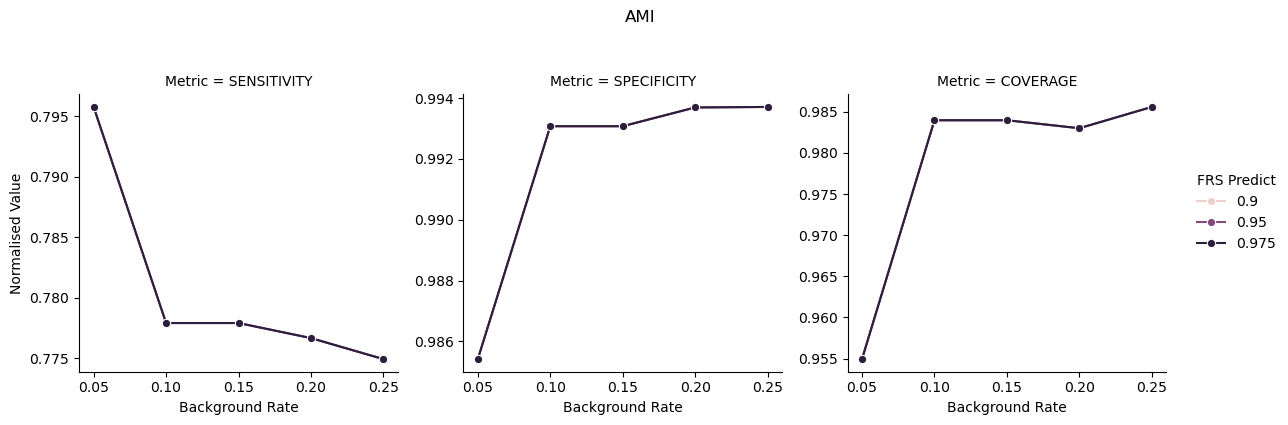

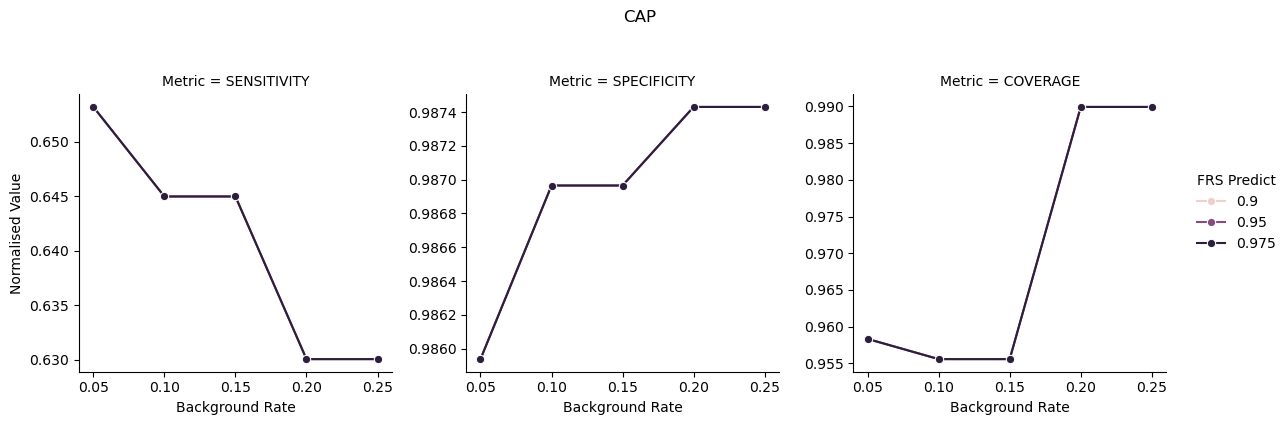

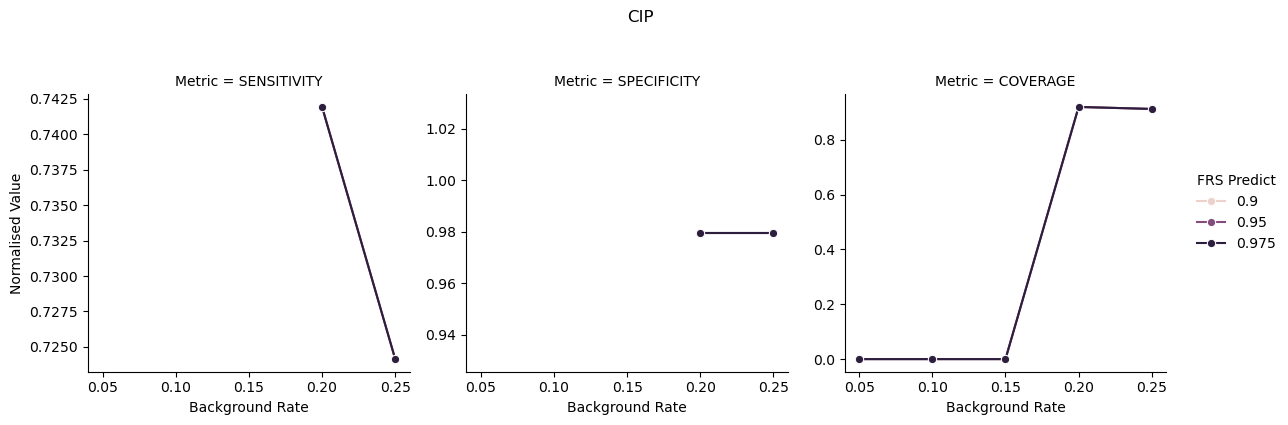

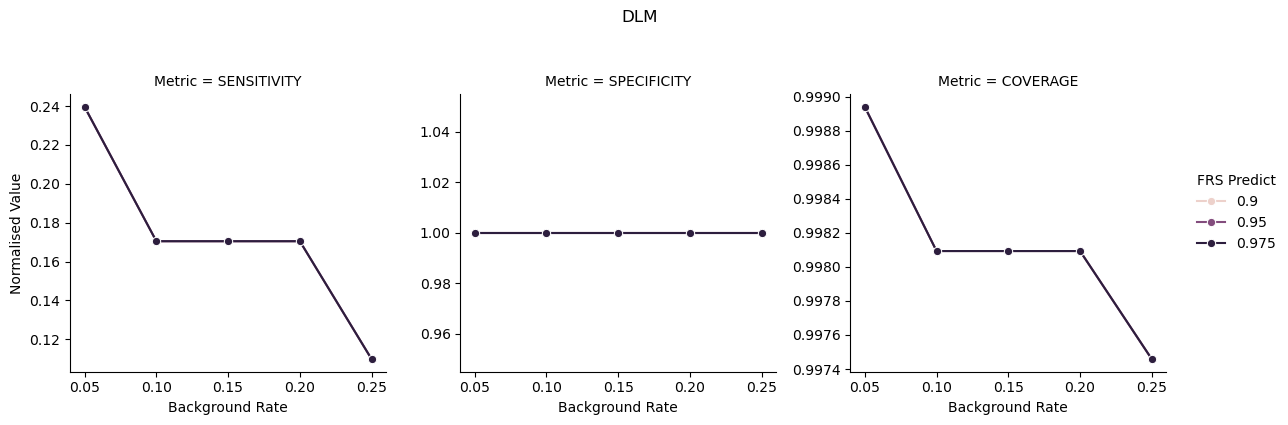

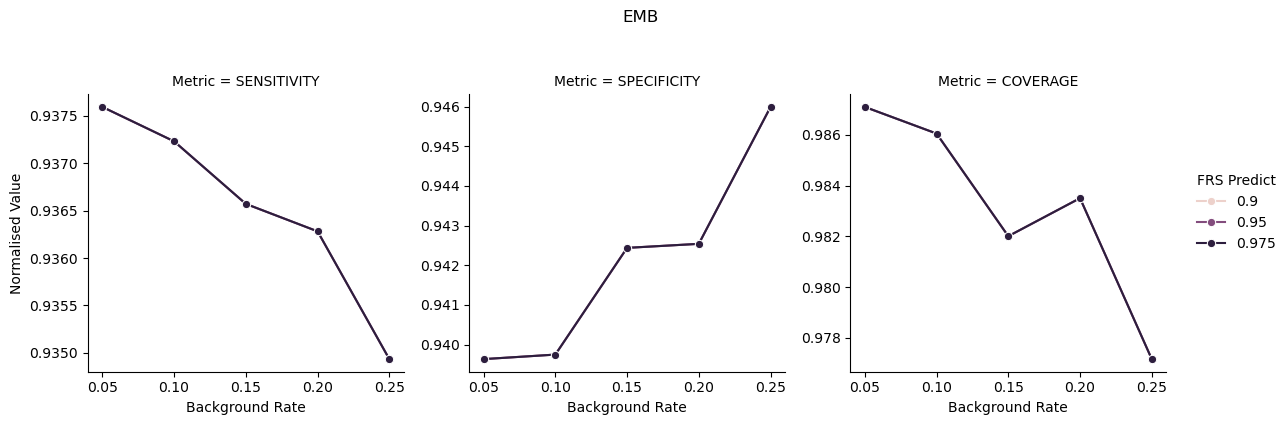

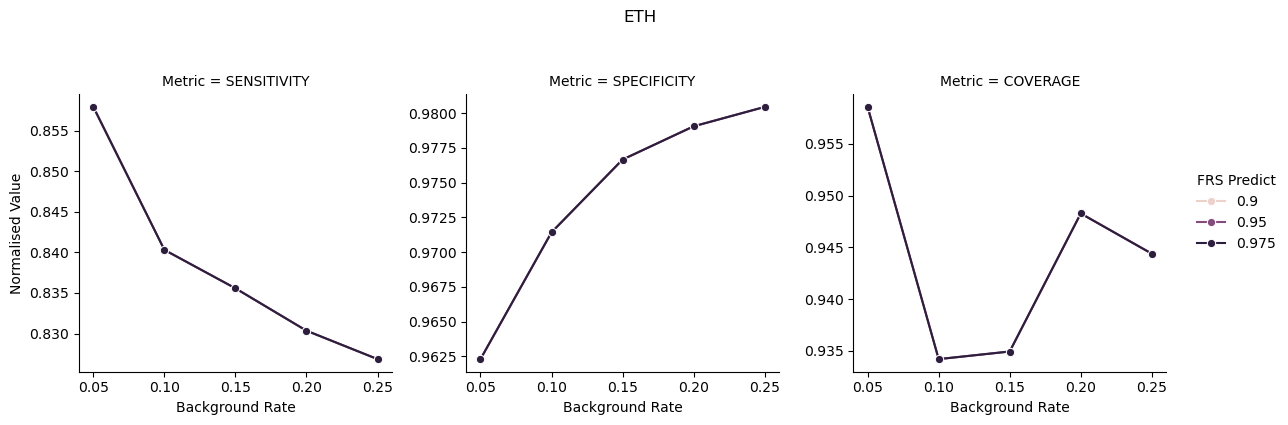

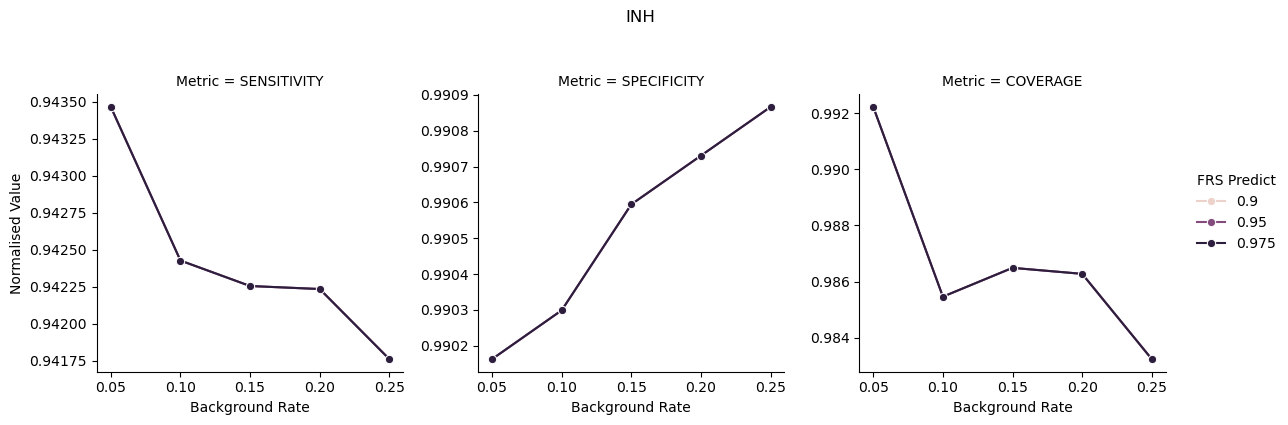

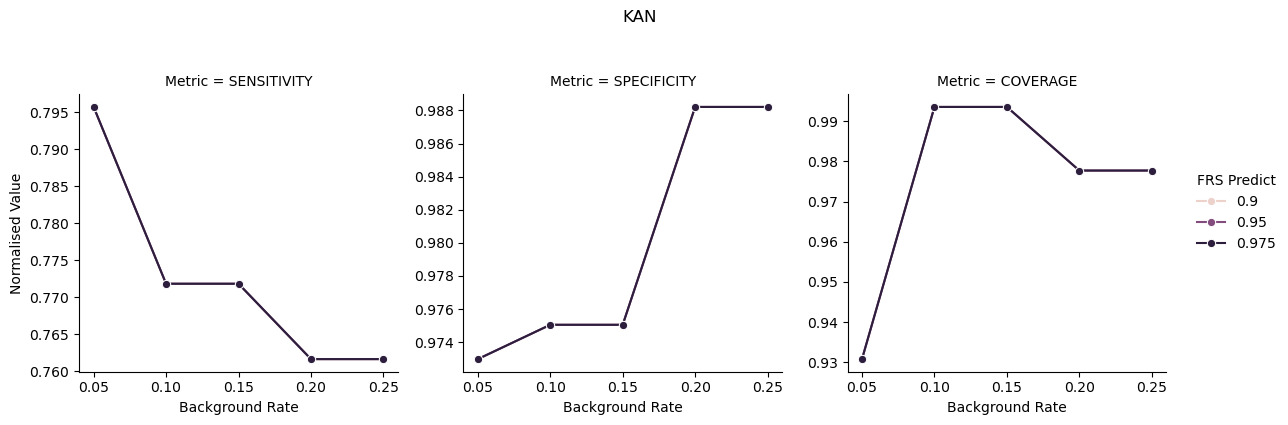

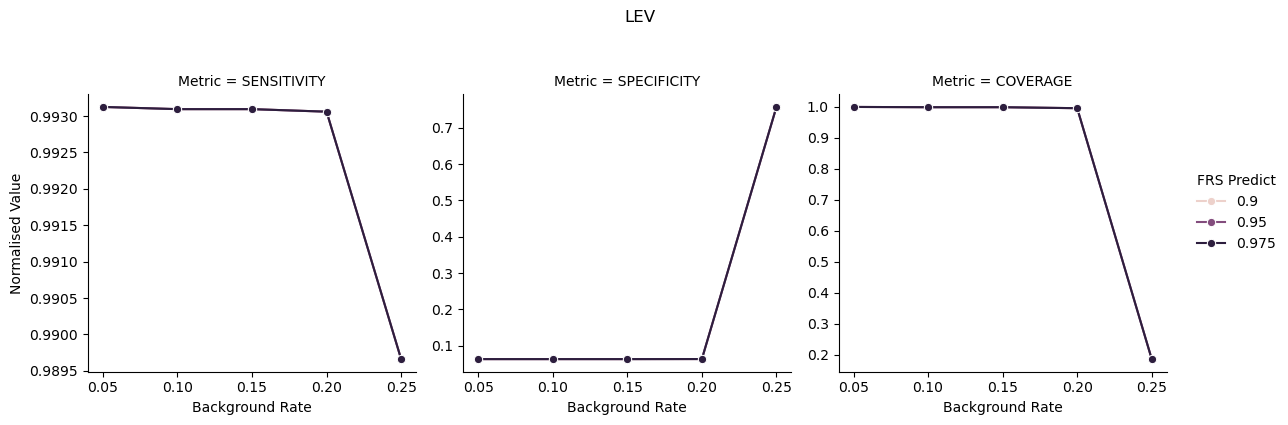

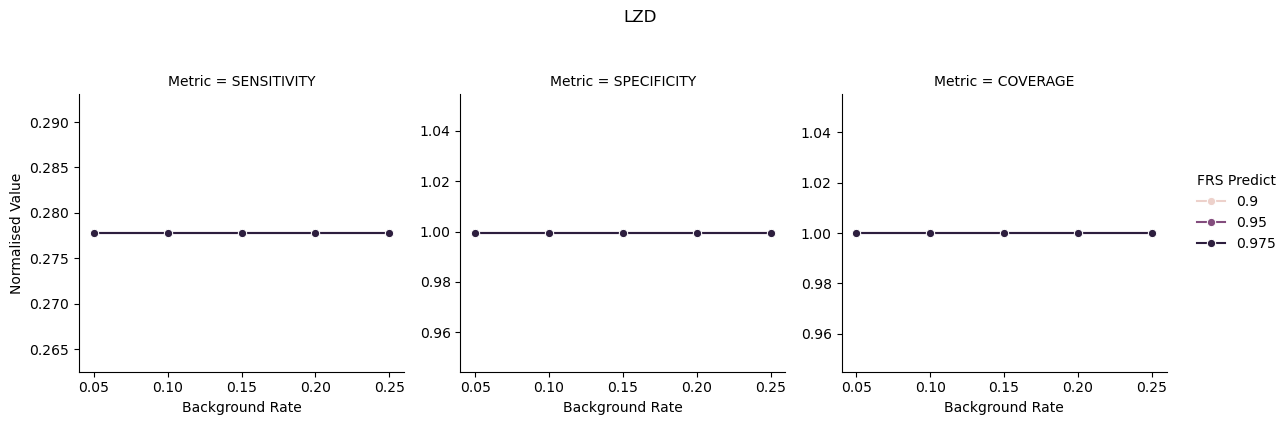

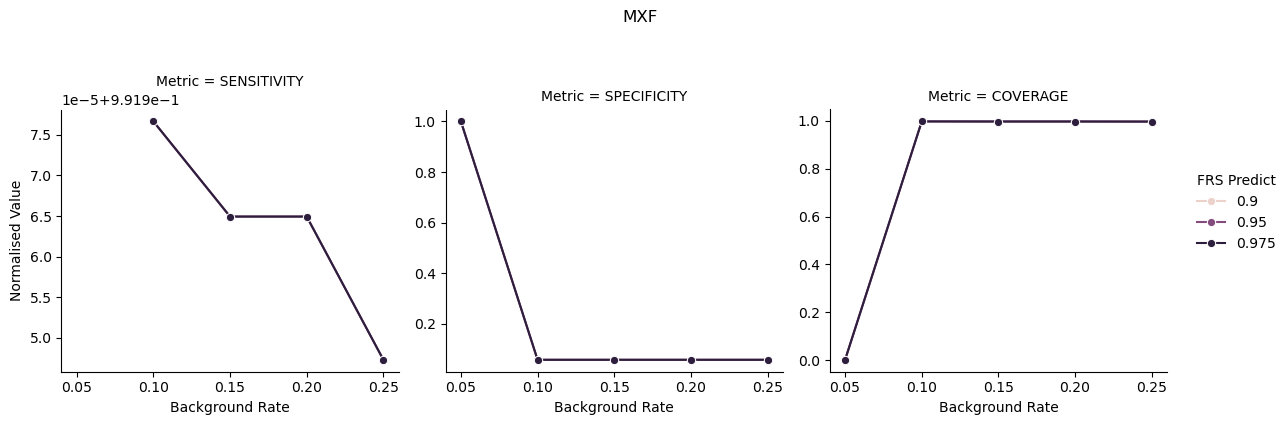

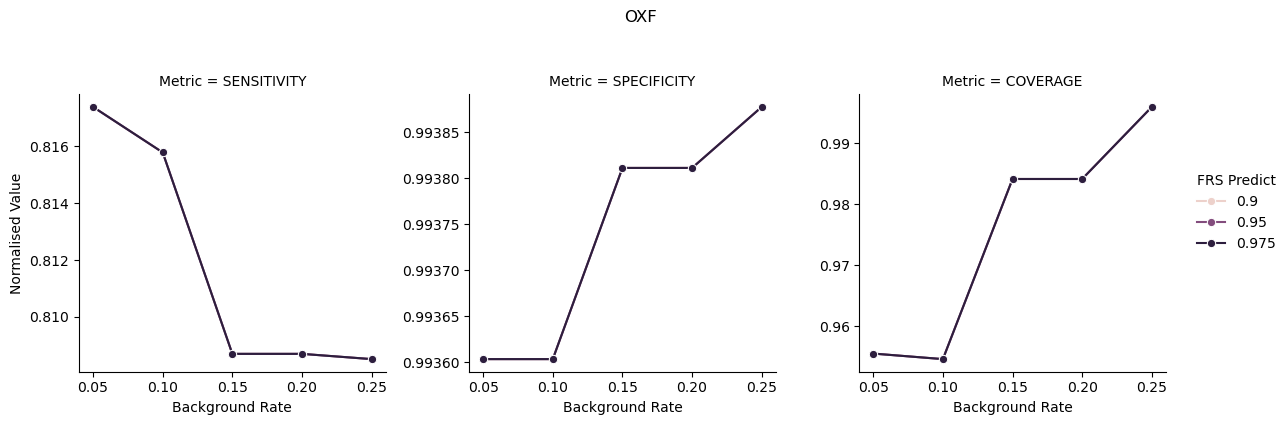

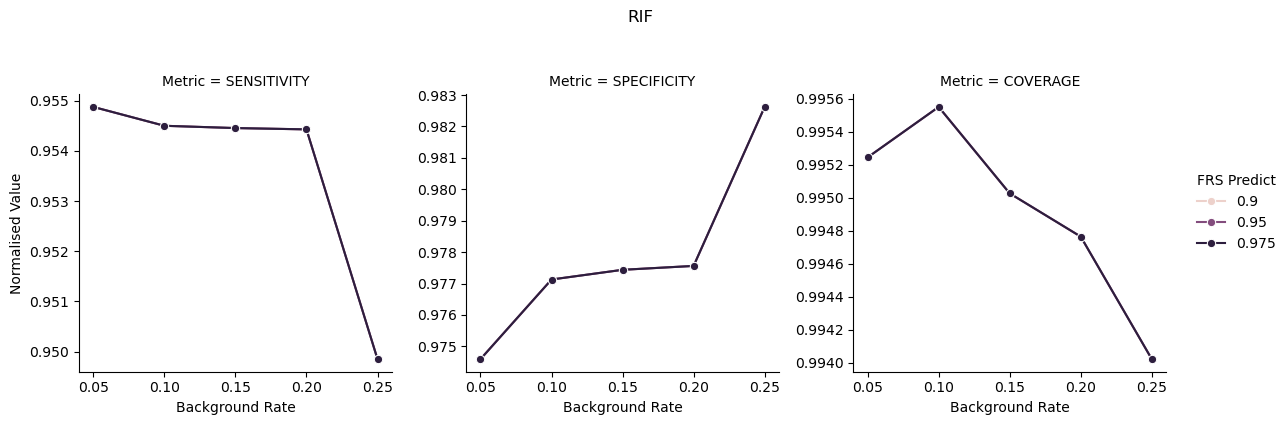

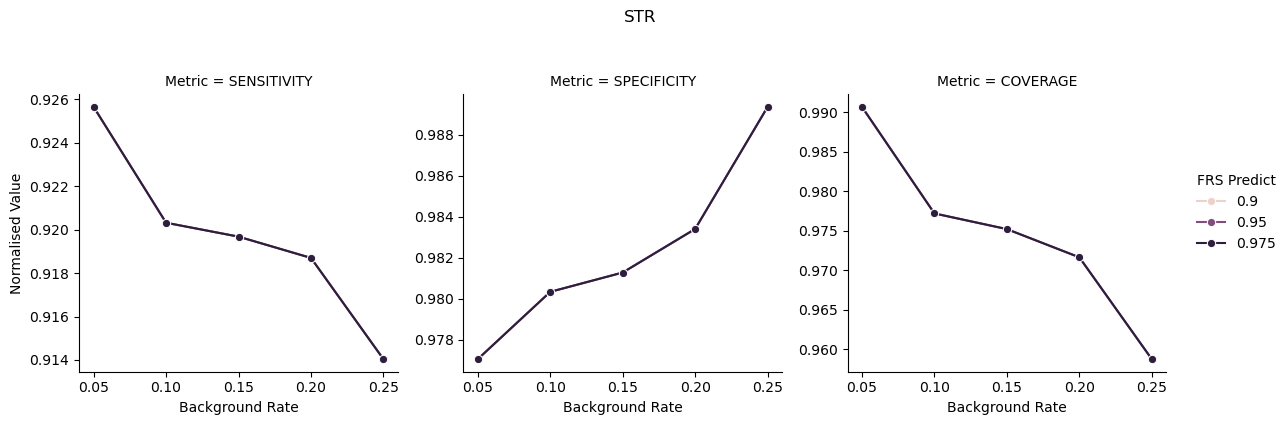

In [ ]:
# Flatten the grid_results dictionary into a DataFrame
df = pd.DataFrame(
    [
        {
            "DRUG": drug,
            "BACKGROUND_RATE": background_rate,
            "p_value": p,
            "SENSITIVITY": metrics.get("sens"),
            "SPECIFICITY": metrics.get("spec"),
            "COVERAGE": metrics.get("cov"),
        }
        for drug, backgrounds in grid_results.items()
        for background_rate, p_values in backgrounds.items()
        for p, metrics in p_values.items()
    ]
)

# Melt the DataFrame for plotting
melted_df = df.melt(
    id_vars=["DRUG", "BACKGROUND_RATE", "p_value"],
    value_vars=["SENSITIVITY", "SPECIFICITY", "COVERAGE"],
    var_name="Metric",
    value_name="Value",
)

for drug in melted_df["DRUG"].unique():
    drug_data = melted_df[melted_df["DRUG"] == drug]
    g = sns.FacetGrid(drug_data, col="Metric", col_wrap=3, sharey=False, height=4)
    g.map_dataframe(sns.lineplot, x="BACKGROUND_RATE", y="Value", hue="p_value", marker="o")
    g.set_axis_labels("Background Rate", "Normalised Value")
    g.add_legend(title="P Value")
    g.figure.suptitle(drug, y=1.05)
    g.tight_layout()
    plt.show()

We need to define a scoring function that will help us decide which set of parameters is optimal for each drug. The simplest is probabaly a weighted sum of sensivitiy, specificiy, and coverage.

In [199]:
#determine best performing catalogue
def weighted_score(df, weights=(0.5, 0.3, 0.2)):
    w1, w2, w3 = weights
    df['Score'] = (
        w1 * df['SENSITIVITY'] +
        w2 * df['SPECIFICITY'] +
        w3 * df['COVERAGE']
    )
    return df.sort_values(by="Score", ascending=False)

opt_cats = weighted_score(df).groupby("DRUG").head(1).reset_index(drop=True)
#pull out R, S, U counts from catalogue
cat_counts = pd.DataFrame([
    {
        "DRUG": opt_cats['DRUG'][i],
        "R": cat["PREDICTION"].value_counts().get("R", 0),
        "S": cat["PREDICTION"].value_counts().get("S", 0),
        "U": cat["PREDICTION"].value_counts().get("U", 0),
        "Total": len(cat)
    }
    for i in opt_cats.index
    for cat in [pd.read_csv(f"./catalogues/{opt_cats['DRUG'][i].lower()}/bg_{opt_cats['BACKGROUND_RATE'][i]}_p_{opt_cats['p_value'][i]}_FRS_0.1.csv")]
])

opt_cats = pd.merge(opt_cats, cat_counts, on='DRUG')
opt_cats['catalogue'] = 'catomatic'
opt_cats

,DRUG,BACKGROUND_RATE,p_value,SENSITIVITY,SPECIFICITY,COVERAGE,Score,R,S,U,Total,catalogue
0,RIF,0.10,0.975,0.954500,0.977129,0.995550,0.969499,39,192,33,264,catomatic
1,INH,0.05,0.975,0.943464,0.990162,0.992217,0.967224,196,313,35,544,catomatic
2,STR,0.05,0.950,0.925651,0.977066,0.990675,0.954080,75,190,26,291,catomatic
3,EMB,0.05,0.975,0.937595,0.939633,0.987106,0.948109,33,630,28,691,catomatic
4,ETH,0.05,0.900,0.857931,0.962311,0.958579,0.909375,124,251,53,428,catomatic
5,OXF,0.25,0.900,0.808511,0.993878,0.995917,0.901602,8,57,10,75,catomatic
6,AMI,0.05,0.950,0.795782,0.985416,0.954935,0.884503,7,229,20,256,catomatic
7,KAN,0.10,0.900,0.771818,0.975049,0.993570,0.877138,7,223,20,250,catomatic
8,CIP,0.20,0.900,0.741935,0.979545,0.919414,0.848714,6,19,10,35,catomatic
9,CAP,0.05,0.900,0.653179,0.985938,0.958333,0.814038,3,44,13,60,catomatic


### Compare with with WHOv2 performance (training set)

Because the WHOv2 catalogue has been parsed into a piezo format, we can easily run predictions of WHOv2 on our training set and compare performance with catomatic's catalogues.

However, the WHO use a binary prediction system, whereby samples containing U mutations are assumed to be S (ie those mutations are removed). However, we can ignore this and use a ternary system to compare to ours (which will also be more informative as it will tell us how many WHO predictions are actual look-ups, and how many are assumptions).

In [ ]:
#calculate WHOv2 performance on training set (using ternary prediction system)
FRS = 0.1
who_results = {}

for drug, file in drug_mutations.items():

    who_catalogue = './data/old/NC_000962.3_WHO-UCN-TB-2023.5_v2.0_GARC1_RFUS.csv'
    if drug in pd.read_csv(who_catalogue)['DRUG'].unique():
        
        mutations = prep_mutations(file)
        phenotypes = prep_phenotypes('./creating_training_validation_sets/cat_drug_long_format_20250117.csv', drug)
        
        # Test the performance of the WHO on the training set for this drug
        all = pd.merge(phenotypes, mutations[mutations.FRS >= 0.1], on=['UNIQUEID'], how='left')
        cm, cov, sens, spec, _, _ = utils.piezo_predict(iso_df=all, drug=drug, catalogue_file=who_catalogue, U_to_S=False, Print=False)
        
        # Save results into grid_results
        who_results[drug] = {'catalogue': 'WHOv2', "SENSITIVITY": sens, "SPECIFICITY": spec, "COVERAGE": cov}



In [ ]:
who_results = pd.DataFrame(who_results).T.reset_index().rename(columns={'index':'DRUG'})

In [200]:
comp_train_perf = pd.concat([who_results, opt_cats[opt_cats.DRUG.isin(pd.read_csv(who_catalogue)['DRUG'].unique())][['DRUG', 'catalogue', 'SENSITIVITY', 'SPECIFICITY', 'COVERAGE']]], ignore_index=True).sort_values(by=['DRUG', 'catalogue'])
comp_train_perf

,DRUG,catalogue,SENSITIVITY,SPECIFICITY,COVERAGE
0,AMI,WHOv2,0.782037,0.985304,0.949191
15,AMI,catomatic,0.795782,0.985416,0.954935
1,CAP,WHOv2,0.640449,0.98547,0.963828
17,CAP,catomatic,0.653179,0.985938,0.958333
2,DLM,WHOv2,0.188889,0.999676,0.990574
21,DLM,catomatic,0.239583,0.999893,0.998941
3,EMB,WHOv2,0.917734,0.94619,0.953021
13,EMB,catomatic,0.937595,0.939633,0.987106
4,ETH,WHOv2,0.852855,0.949752,0.886354
14,ETH,catomatic,0.857931,0.962311,0.958579


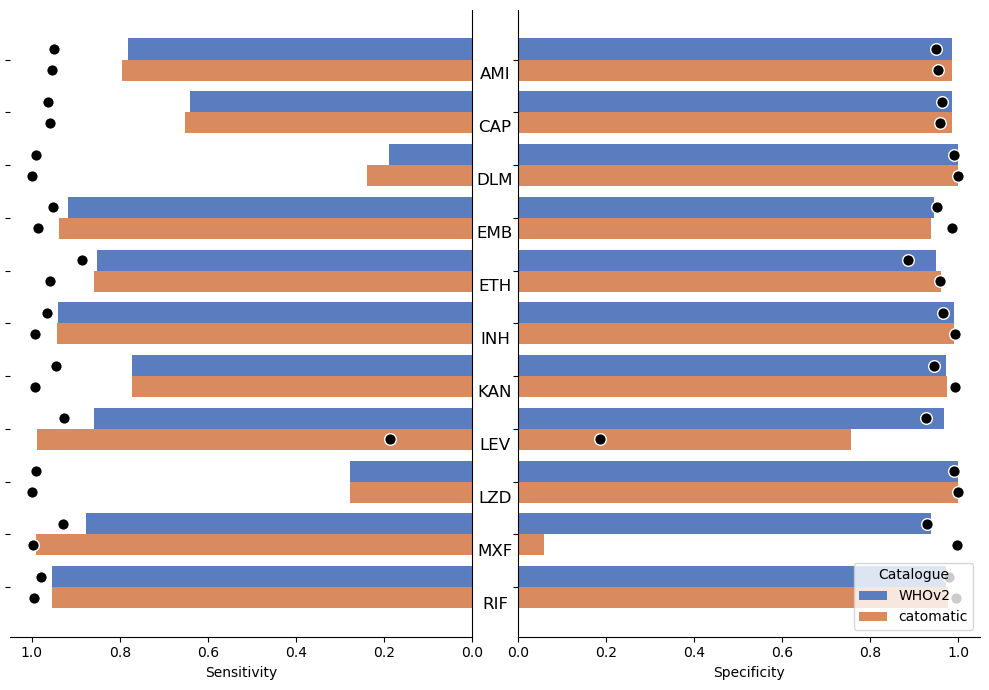

In [203]:

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(10, 7), gridspec_kw={'width_ratios': [1, 1]})

# Sensitivity Plot (Left Side)
sns.barplot(
    data=comp_train_perf,
    y="DRUG", x="SENSITIVITY", hue="catalogue",
    dodge=True, ax=ax1, palette="muted"
)
ax1.set_xlabel("Sensitivity")
ax1.invert_xaxis()  # Flip the x-axis for back-to-back effect
ax1.legend_.remove()  # Remove duplicate legend
ax1.set_ylabel("")  # Remove the left-side y-axis label
ax1.set_yticklabels([])  # Remove y-tick labels
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)


# Specificity Plot (Right Side)
sns.barplot(
    data=comp_train_perf,
    y="DRUG", x="SPECIFICITY", hue="catalogue",
    dodge=True, ax=ax2, palette="muted"
)
ax2.set_xlabel("Specificity")
ax2.legend(title="Catalogue", loc="lower right")
ax2.set_ylabel("")  # Remove the right-side y-axis label
ax2.set_yticklabels([])  # Remove y-tick labels
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Add the drug names in the middle between the plots
middle_positions = range(1, len(comp_train_perf["DRUG"].unique())+1)
for y_pos, label in zip(middle_positions, comp_train_perf["DRUG"].unique()[::-1]):
    fig.text(
        0.5,  # x-coordinate: centered between the plots
        (y_pos+0.7) / (len(middle_positions)+2.2),  # Normalize y-coordinate
        label,  # Text label
        ha='center', va='center', fontsize=12, rotation=0
    )

for drug in comp_train_perf["DRUG"].unique():
    drug_data = comp_train_perf[comp_train_perf["DRUG"] == drug]
    y_position = middle_positions[list(comp_train_perf["DRUG"].unique()).index(drug)]-1

    # Plot on Sensitivity chart (ax1)
    ax1.scatter(
        drug_data["COVERAGE"],
        [y_position - 0.2 if cat == "WHOv2" else y_position + 0.2 for cat in drug_data["catalogue"]],
        s=70, c="black", edgecolors="white", label=None  # Adjust marker size (s) and color (c) as needed
    )
    ax2.scatter(
        drug_data["COVERAGE"],
        [y_position - 0.2 if cat == "WHOv2" else y_position + 0.2 for cat in drug_data["catalogue"]],
        s=70, c="black", edgecolors="white", label=None  # Adjust marker size (s) and color (c) as needed
    )

plt.tight_layout()
plt.subplots_adjust(wspace=0.1)  

# Show the plot
plt.show()


 ### Compare with WHOv2 performance (validation set)

In [ ]:
#Calculate catomatic catalogue performance on validation set: 

FRS = 0.1
catomatic_results = {}

for drug, file in drug_mutations.items():

    who_catalogue = './data/old/NC_000962.3_WHO-UCN-TB-2023.5_v2.0_GARC1_RFUS.csv'
    if drug in pd.read_csv(who_catalogue)['DRUG'].unique():
        
        catfile=(f"./catalogues/{drug.lower()}/bg_{opt_cats[opt_cats.DRUG==drug]['BACKGROUND_RATE'].iloc[0]}_"
                 f"p_{opt_cats[opt_cats.DRUG==drug]['p_value'].iloc[0]}_FRS_{FRS}.csv")
        mutations = prep_mutations(file)
        phenotypes = prep_phenotypes('./creating_training_validation_sets/validation_data_long_format_20250117.csv', drug)
        #if validation data actually contains the drug
        if len(phenotypes)>0:
            # Test the performance of the WHO on the training set for this drug
            all = pd.merge(phenotypes, mutations[mutations.FRS >= 0.1], on=['UNIQUEID'], how='left')
            cm, cov, sens, spec, _, _ = utils.piezo_predict(iso_df=all, drug=drug, catalogue_file=catfile, U_to_S=False, Print=False)
            
            # Save results into grid_results
            catomatic_results[drug] = {'catalogue': 'catomatic', "SENSITIVITY": sens, "SPECIFICITY": spec, "COVERAGE": cov}

AMI
CAP
DLM
EMB
INH
KAN
LEV
LZD
MXF
RIF


Although this code would allow one to validate the catalogue on an independent test sets, and although we have the samples, we do not have the mutations. 

THerefore, cannot validate currently, but as I'm going to ultimately run on this on a different dataset anyway, its probably not worth following up.

## Compare content to WHOv2

The complications are:
- Both contains default rules
- Both contain expert rules (such as lof rules)

Therefore, how do we compare across - as a LoF in 1 will cover all such mutatations in the other, but some of these may be false positives, for example. 

If we want a comparison of effective content, then we should include the expert rules. But need to be careful, as there is a hierarchy to the rules.

The best thing to do is use piezo, which will handle what the rules actually mean and what falls under them.

But then should also highlight which of these matches/mismathces are due to rules, so can evaluate ability of the catalogue building step.

In the case of cat1 having rules, and cat2 not (e.g) - could just replace the rule with all the relevant entries in cat2 - this should then count them up correctly (irrespetive of phenotype matches). Need to be careful though, as catomatic cataogue may contain rule + specific variant, so just make sure duplicates are dropped after the merge and specific mutations are prioritised.

The way to think about it, is not a comparison of how many rows in each catalogue. But rather is a number of total specific mutations explicitly represented by both catalogues, some are specificly defined and some are encoded in rules. We can compare how many of these both catalogues cover.


In [453]:
#Prep data for comparisons:
who = pd.read_csv('./data/old/NC_000962.3_WHO-UCN-TB-2023.5_v2.0_GARC1_RFUS.csv')
who['EVIDENCE'] = who['EVIDENCE'].apply(utils.str_to_dict)
#filter out default rules
who = who[~who['EVIDENCE'].apply(lambda x: isinstance(x, dict) and 'reporting_rule' in x)]
#keep only R and S classifications
who = who[who.PREDICTION.isin(['R','S'])]
#filter out rules
who_no_rules = who[~who['MUTATION'].str.contains(r'[*?=]', regex=True)]
#only keep rules
who_rules_only = who[who['MUTATION'].str.contains(r'[*?=]', regex=True)]


#prep catomatic catalogues
valid_drugs = opt_cats[opt_cats.DRUG.isin(who.DRUG.unique())]
cats = valid_drugs.apply(
    lambda row: pd.read_csv(f"./catalogues/{row['DRUG'].lower()}/bg_{row['BACKGROUND_RATE']}_p_{row['p_value']}_FRS_0.1.csv"),
    axis=1
).tolist()
cat = pd.concat(cats)

cat['EVIDENCE'] = cat['EVIDENCE'].apply(utils.str_to_dict)
#filter out default rules
cat = cat[~cat['EVIDENCE'].apply(lambda x: isinstance(x, dict) and 'default_rule' in x)]
#keep only R and S classifications
cat = cat[cat.PREDICTION.isin(['R','S'])]
#filter out rules
cat_no_rules = cat[~cat['MUTATION'].str.contains(r'[*?=]', regex=True)]
#only keep rules
cat_rules_only = cat[cat['MUTATION'].str.contains(r'[*?=]', regex=True)]

valid_drugs = cat[cat.DRUG.isin(who.DRUG.unique())].DRUG.unique()


In [ ]:
#Including expert rules

expanded_catalogues = {}

row = {
    'GENBANK_REFERENCE': 'NC_000962.3',
    'CATALOGUE_NAME': 'WHO-UCN-GTB-PCI-2023.5',
    'CATALOGUE_VERSION': 2,
    'CATALOGUE_GRAMMAR': 'GARC1',
    'PREDICTION_VALUES': 'RFUS',
    'DRUG': None,
    'MUTATION': None,
    'PREDICTION': None,
    'SOURCE': {},
    'EVIDENCE': {},
    'OTHER': {}
}

for drug in valid_drugs:

    #catalogues filtered by drug
    cat_drug = cat[cat.DRUG==drug]
    who_drug = who[who.DRUG==drug]
    #catalogues with rules removed, filtered for drug
    cat_no_rules_drug = cat_no_rules[cat_no_rules.DRUG==drug]
    who_no_rules_drug = who_no_rules[who_no_rules.DRUG==drug]
    #catalogue expert rules (not defaults) filtered for drug
    who_rules_drug = who_rules_only[who_rules_only.DRUG==drug]
    cat_rules_drug = cat_rules_only[cat_rules_only.DRUG==drug]
    #add placeholder rules to rule catalogues so avoid piezo error
    for i in 'RFS':
        row['PREDICTION'] = i
        row['MUTATION'] = 'placeholder@A1A'
        row['DRUG'] = drug
        who_rules_drug = pd.concat([who_rules_drug, pd.DataFrame([row])], ignore_index=True)
        cat_rules_drug = pd.concat([cat_rules_drug, pd.DataFrame([row])], ignore_index=True)
   
    genes = set(who_drug['MUTATION'].apply(lambda x: x.split('@')[0]).tolist() + cat_drug['MUTATION'].apply(lambda x: x.split('@')[0]).tolist())
    #add a default wildcard U rule to rule catalogues so that a U is thrown if a mutation is not shared
    for gene in genes:
        for mut in [f'{gene}@*?', f'{gene}@-*?']:
            row['PREDICTION'] = 'U'
            row['MUTATION'] = mut
            row['DRUG'] = drug
            who_rules_drug = pd.concat([who_rules_drug, pd.DataFrame([row])], ignore_index=True)
            cat_rules_drug = pd.concat([cat_rules_drug, pd.DataFrame([row])], ignore_index=True)

    #write out rule catalogues so piezo can read them in and scan the other non-rule catalogue
    cat_rules_drug['EVIDENCE'] = cat_rules_drug['EVIDENCE'].to_json()
    cat_rules_drug.to_csv(f'./catalogues/temp/cat_rules_only.csv')
    cat_rules_piezo = piezo.ResistanceCatalogue(f'./catalogues/temp/cat_rules_only.csv')

    who_rules_drug['EVIDENCE'] = who_rules_drug['EVIDENCE'].to_json()
    who_rules_drug.to_csv(f'./catalogues/temp/who_rules_only.csv')
    who_rules_piezo = piezo.ResistanceCatalogue(f'./catalogues/temp/who_rules_only.csv')

    #use who catalogue to scan catomatic non-rule catalogue to find variants that fall under that rule
    vars = []
    for var in cat_no_rules_drug.MUTATION:
        try:
            prediction = who_rules_piezo.predict(var)
            if prediction[drug] in ['R', 'S']:
                vars.append((var, prediction[drug]))
        except ValueError:
            continue
    #add variants from catomatic catalogue that fall under who rules to who non-rule catalogue
    for m, p in vars:
        row['MUTATION'] = m
        row['PREDICTION'] = p
        row['EVIDENCE'] = {'expanded_rule'}
        who_no_rules_drug = pd.concat([who_no_rules_drug, pd.DataFrame([row])], ignore_index=True)
    #use catomatic rule catalogue to scan who non-rule catalogue to find variants that fall under that rule
    vars = []
    for var in who_no_rules_drug.MUTATION:
        try:
            prediction = cat_rules_piezo.predict(var)
            if prediction[drug] in ['R', 'S']:
                vars.append((var, prediction[drug]))
        except ValueError:
            continue
    #add variants from who catalogue that fall under catoamtic rules to catomatic non-rule catalogue
    for m, p in vars:
        row['MUTATION'] = m
        row['PREDICTION'] = p
        row['EVIDENCE'] = {'expanded_rule'}
        cat_no_rules_drug = pd.concat([cat_no_rules_drug, pd.DataFrame([row])], ignore_index=True)

    expanded_catalogues[drug] = {
        'catomatic': cat_no_rules_drug.drop_duplicates('MUTATION'), 
        'who':who_no_rules_drug.drop_duplicates('MUTATION'), 
        'merged':pd.merge(who_no_rules_drug, cat_no_rules_drug, on='MUTATION', how='outer', suffixes=('_who', '_cat'))
        }

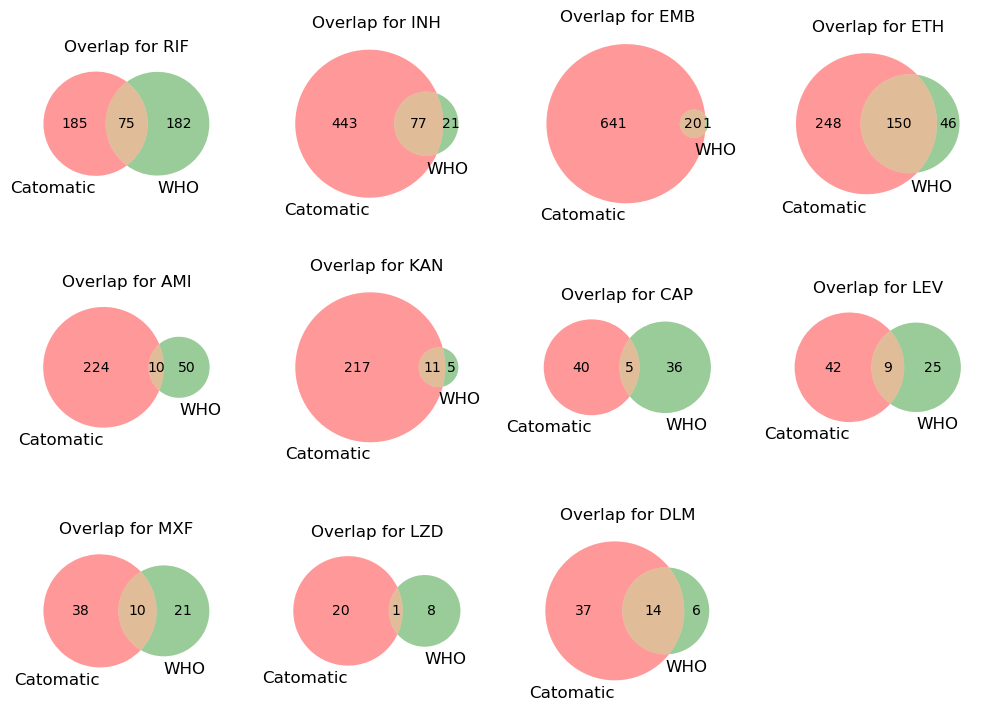

In [614]:

n_cols = 4
n_rows = -(-len(valid_drugs) // n_cols)  # Calculate rows based on number of drugs

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5))
axes = axes.flatten()

idx=0
for drug, v in expanded_catalogues.items():
    
    merged = v['merged']
    shared_variants = len(merged[(~merged.PREDICTION_who.isna()) & (~merged.PREDICTION_cat.isna())])
    who_only_variants = len(merged[(~merged.PREDICTION_who.isna()) & (merged.PREDICTION_cat.isna())])
    catomatic_only_variants = len(merged[(merged.PREDICTION_who.isna()) & (~merged.PREDICTION_cat.isna())])

    ax = axes[idx]
    venn_diagram = venn2(
        subsets=(catomatic_only_variants, who_only_variants, shared_variants),
        set_labels=('Catomatic', 'WHO'),
        ax=ax
    )
    ax.set_title(f"Overlap for {drug}")
    idx+=1

for ax in axes[len(valid_drugs):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

In [615]:
#pull out R and S counts
def extract_value(value, *keys):
    try:
        for key in keys:
            value = value[key]
        return value
    except (KeyError, IndexError, TypeError):
        return None

for drug, v in expanded_catalogues.items():
    v['merged']['solo_R_who'] = v['merged']['EVIDENCE_who'].apply(lambda x: extract_value(x, 'Observed_samples', 'Present_SOLO_R'))
    v['merged']['solo_S_who'] = v['merged']['EVIDENCE_who'].apply(lambda x: extract_value(x, 'Observed_samples', 'Present_SOLO_S'))
    v['merged']['solo_R_cat'] = v['merged']['EVIDENCE_cat'].apply(lambda x: extract_value(x, 'contingency', 0, 0))
    v['merged']['solo_S_cat'] = v['merged']['EVIDENCE_cat'].apply(lambda x: extract_value(x, 'contingency', 0, 1))


Can plot the number of solo counts observed for each variant shared across catalogues (not including rules, as the number of counrs in a rule can't be expanded to represent the counts of indvidual mutaitons that fall under that rule (ie the number of points will be less than the shared counts above, which include the rules) - this is automatically handled as the evidence columns for variants expanded from rules dont contain counts).

Could perhaps also plot proportion of resistance?

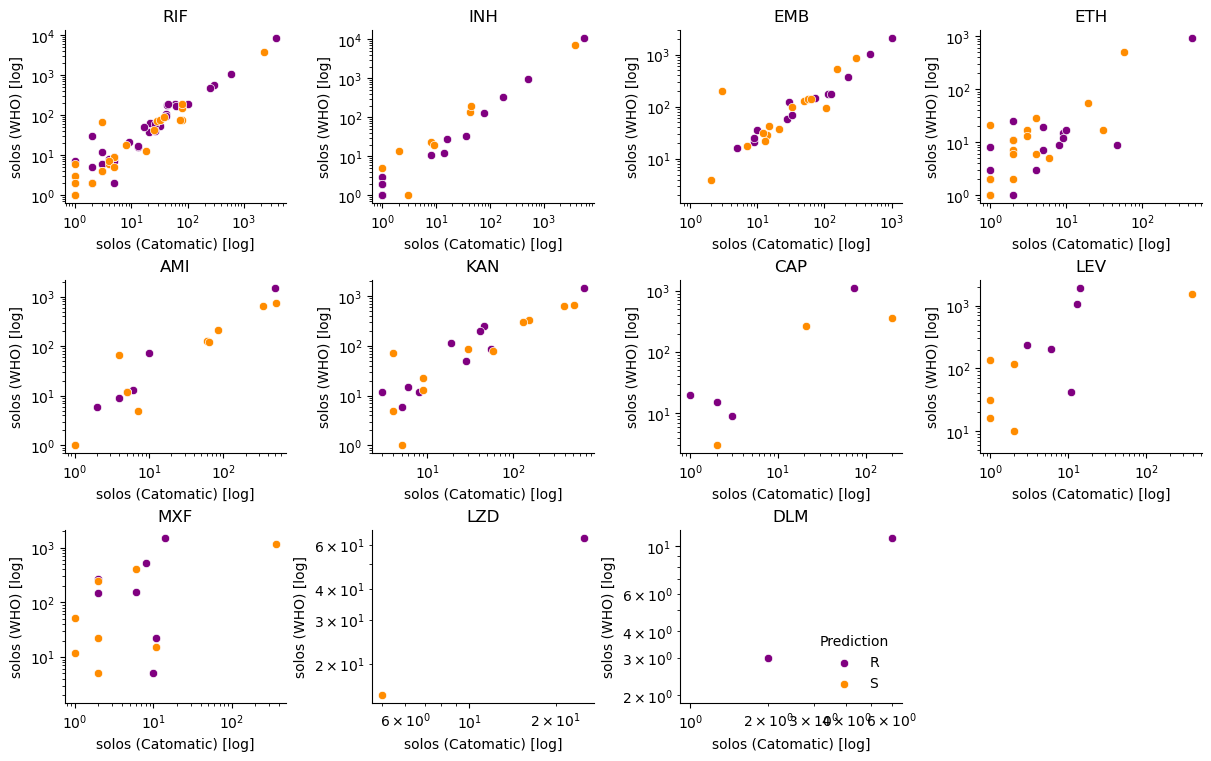

In [616]:
n_cols = 4  # Number of columns
n_rows = math.ceil(len(valid_drugs) / n_cols)  # Calculate rows needed
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 2.5 * n_rows), constrained_layout=True)

axes = axes.flatten()

idx=0
for drug, v in expanded_catalogues.items():

    shared = v['merged'][(~v['merged'].PREDICTION_who.isna())&(~v['merged'].PREDICTION_cat.isna())]
    
    ax = axes[idx]
    sns.scatterplot(data=shared, x='solo_R_cat', y='solo_R_who', ax=ax, color='purple', label='R')
    sns.scatterplot(data=shared, x='solo_S_cat', y='solo_S_who', ax=ax, color='darkorange', label='S')

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_title(f"{drug}")
    ax.set_xlabel("solos (Catomatic) [log]")
    ax.set_ylabel("solos (WHO) [log]")
    sns.despine(ax=ax)
    if idx == len(valid_drugs)-1:
        ax.legend(title="Prediction", frameon=False, loc='lower right')
    
    else:
        ax.legend().remove()
    
    idx += 1
    
# Hide unused subplots if any
for j in range(idx , len(axes)):
    axes[j].axis('off')

# Show the grid of plots
plt.show()


In [599]:
def classify_predictions(row):
    if not pd.isna(row['PREDICTION_who']) and not pd.isna(row['PREDICTION_cat']):
        return f"{row['PREDICTION_cat']}.{row['PREDICTION_who']}"
    elif pd.isna(row['PREDICTION_who']) and not pd.isna(row['PREDICTION_cat']):
        return f"{row['PREDICTION_cat']}.X"
    elif not pd.isna(row['PREDICTION_who']) and pd.isna(row['PREDICTION_cat']):
        return f"X.{row['PREDICTION_who']}"
    else:
        return "X.X"  # Default case if both are NaN


all_drugs_merged = pd.concat(expanded_catalogues[drug]['merged'] for drug in valid_drugs)

all_drugs_merged['PREDICTION_PAIR'] = all_drugs_merged.apply(classify_predictions, axis=1)

all_drugs_merged['DRUG'] = all_drugs_merged['DRUG_who'].combine_first(all_drugs_merged['DRUG_cat'])


The below is a finer grain summary of what each catalogue contains, taking into account expert rules as above. The sum of these should match the venn diagrams above.

In [ ]:
summary_table = (
    all_drugs_merged.groupby(['DRUG', 'PREDICTION_PAIR'])
    .size()
    .unstack(fill_value=0)  # Pivot table to create columns for prediction pairs
    .reset_index()  # Resets the index, moving 'PREDICTION_PAIR' into a column
)

summary_table.rename(columns={'DRUG': 'DRUG'}, inplace=True)
summary_table['total'] = summary_table.drop(columns=['DRUG']).sum(axis=1)
summary_table.columns.name = None

summary_table

,DRUG,R.R,R.S,R.X,S.R,S.S,S.X,X.R,X.S,total
0,AMI,4,0,3,0,6,221,0,50,284
1,CAP,3,0,0,1,1,40,13,23,81
2,DLM,12,0,4,2,0,33,6,0,57
3,EMB,13,0,20,0,7,621,0,1,662
4,ETH,75,0,59,74,1,189,45,1,444
5,INH,72,0,138,3,2,305,18,3,541
6,KAN,7,0,0,0,4,217,1,4,233
7,LEV,4,0,0,3,2,42,11,14,76
8,LZD,1,0,0,0,0,20,7,1,29
9,MXF,5,1,0,3,1,38,10,11,69


Ignoring rules (as cant plot individual isoalte counts), the plots below give the number of isolates used in the classifications, and the repsetive predicted phenotypes, for variants that are either in both catalogues with R/S labels, or for variants only in 1 catalogue.

Helps identify the kind of phenotype mismathces being made, and the amount of data behind each mismatch.

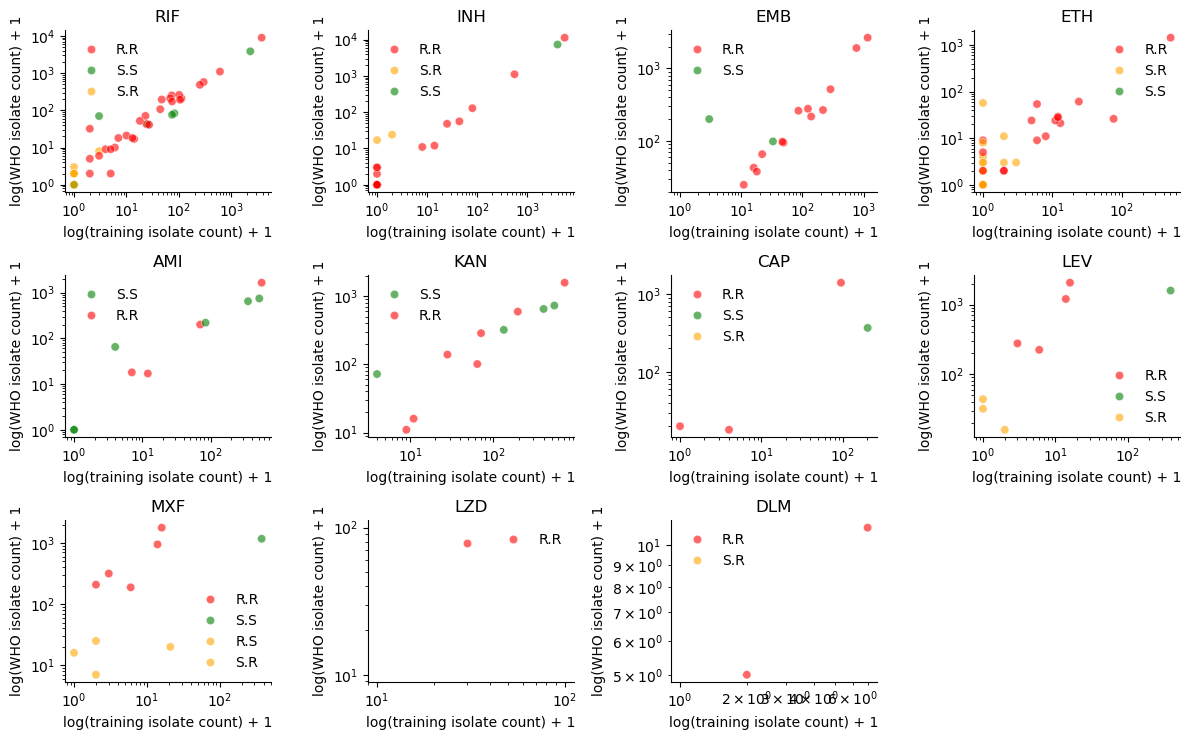

In [682]:
prediction_colors = {
    "R.R": "red", "S.S": "green", "R.S": "orange", "S.R": "orange",
    "X.S": "black",  "X.R": "blue", 
     "S.X": "green", "R.X": "pink",
}

def process_drug_data(df):
    df = df.copy()
    df['x'] = df['solo_R_cat'] + df['solo_S_cat']
    df['y'] = df['solo_R_who'] + df['solo_S_who']
    return df

def plot_grid_counts(df):

    n_cols=4
    n_rows = int(np.ceil(len(valid_drugs) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 2.5 * n_rows))
    axes = axes.flatten()

    idx = 0
    for drug in valid_drugs:
        sns.scatterplot(
            data=df[df.DRUG==drug], x="x", y="y", hue="PREDICTION_PAIR", palette=prediction_colors, alpha=0.6, ax=axes[idx]
        )
        axes[idx].set_xscale("log")
        axes[idx].set_yscale("log")
        axes[idx].set_title(drug)
        axes[idx].set_xlabel("log(training isolate count) + 1")
        axes[idx].set_ylabel("log(WHO isolate count) + 1")
        axes[idx].legend(frameon=False) 
        sns.despine(ax=axes[idx])
        idx += 1

    # Hide unused subplots
    for j in range(len(valid_drugs), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


shared = process_drug_data(all_drugs_merged[(~all_drugs_merged.PREDICTION_PAIR.str.contains('X'))])
#expliclity filter out rows that derive from rules (athough here unnecessary as nans in the x andy columns wont be counted)
shared = shared[
    (shared.EVIDENCE_who != {'expanded_rule'}) | 
    (shared.EVIDENCE_cat != {'expanded_rule'})
]
plot_grid_counts(shared)



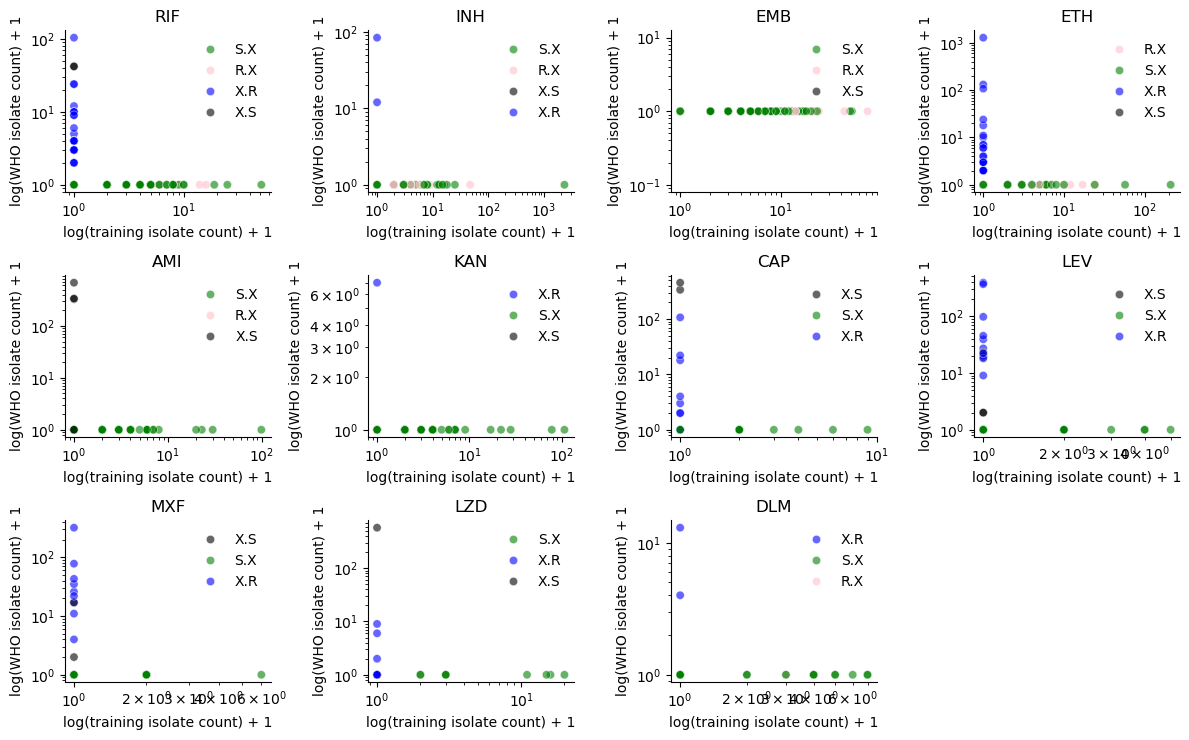

In [683]:
not_shared = process_drug_data(all_drugs_merged[(all_drugs_merged.PREDICTION_PAIR.str.contains('X'))])
#expliclity filter out rows that derive from rules
not_shared = not_shared[
    (not_shared.EVIDENCE_who != {'expanded_rule'}) | 
    (not_shared.EVIDENCE_cat != {'expanded_rule'})
]
not_shared['x'] = not_shared['x'].fillna(1)
not_shared['y'] = not_shared['y'].fillna(1)


plot_grid_counts(not_shared)